In [299]:
import pandas as pd 
import numpy as np 
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import confusion_matrix

In [5]:
result = pyreadr.read_r(r'D:\Projects\ResourcePackage\source\R\Framework\Data\waterDataTraining.RDS') # also works for RData

# df[df["EVENT"]]
df = list(result.items())[0][1]
df["anomaly"] = df.apply(lambda x: 1 if x.EVENT else 0, axis =1)
df.dropna(inplace = True)
# df["EVENT"]

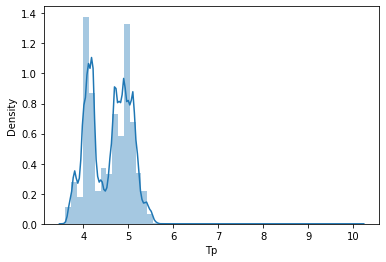

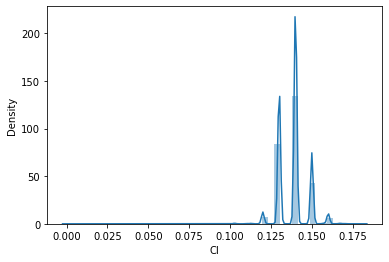

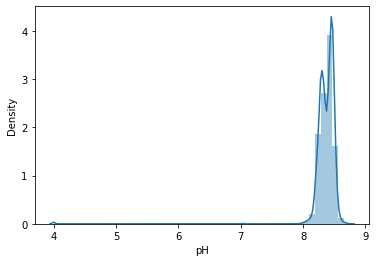

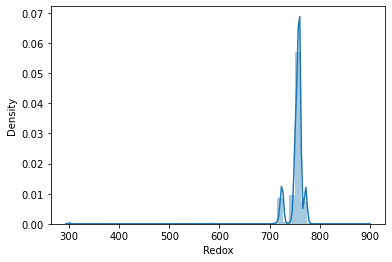

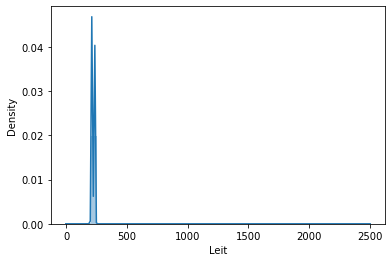

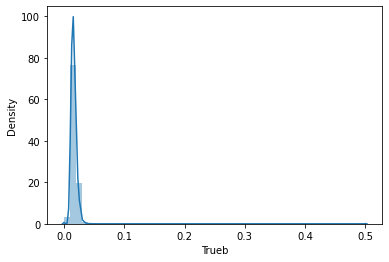

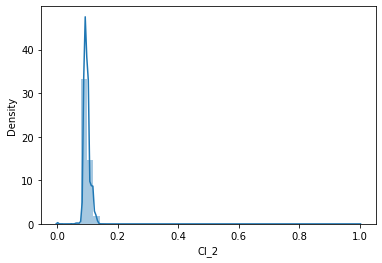

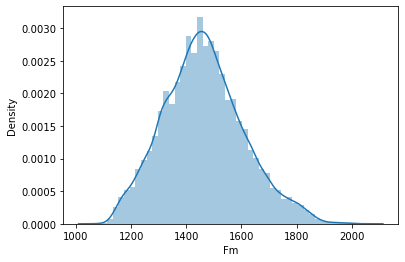

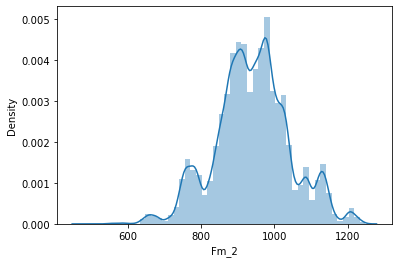

In [11]:
# df.columns
cols = [ 'Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm','Fm_2']
for col in cols:
    sns.distplot(df[col])
    plt.show()

In [94]:
### test train split
X_train, X_test, y_train, y_test = train_test_split(df[cols].astype(float), df.anomaly, test_size=0.3, random_state=42)

### standardizing the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)

In [127]:
# X_train_normalized
class Autoencoder(nn.Module):
    def __init__(self, input_size, reduced_size, drop_out):
        intermediate_layer_size = int(input_size/2)
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(9,7),
            nn.BatchNorm1d(7),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(7, 3),
            nn.BatchNorm1d(3),
            nn.ReLU(),
            nn.Dropout(drop_out)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 5),
            nn.BatchNorm1d(5),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(5, 7),
            nn.BatchNorm1d(7),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(7, 9)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def training_data(model,batch_size, data, num_epochs,learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        losses = 0
        for data in train_loader:
            optimizer.zero_grad()
            x = data.to(device).to(torch.float32)
            y = model.forward(x)
            loss = criterion(y, x)
            loss.backward()
            optimizer.step()
            losses +=loss.item()
            
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, losses/len(train_loader)))
    print("Training completed.")
    return model

def predict(model,test_data):
    test_data = torch.from_numpy(test_data).to(device).to(torch.float32)
    with torch.no_grad():
        return model.forward(test_data)
    
def mse(x,y):
    xpred_np = x.to("cpu").numpy()
    return np.sum((xpred_np-y)**2, axis =1)
    

In [250]:
## initializiing the model
input_size = X_train_normalized.shape[1] 
reduced_size = 3
drop_out = 0.0
model = Autoencoder(input_size,reduced_size,drop_out).to(device)

In [252]:
trained_model = training_data(model,batch_size=2048, data = X_train_normalized, num_epochs=250,learning_rate=0.01)

Epoch [1/250], Loss: 0.2425
Epoch [2/250], Loss: 0.2299
Epoch [3/250], Loss: 0.2234
Epoch [4/250], Loss: 0.2260
Epoch [5/250], Loss: 0.2288
Epoch [6/250], Loss: 0.2316
Epoch [7/250], Loss: 0.2267
Epoch [8/250], Loss: 0.2314
Epoch [9/250], Loss: 0.2229
Epoch [10/250], Loss: 0.2226
Epoch [11/250], Loss: 0.2210
Epoch [12/250], Loss: 0.2246
Epoch [13/250], Loss: 0.2220
Epoch [14/250], Loss: 0.2207
Epoch [15/250], Loss: 0.2226
Epoch [16/250], Loss: 0.2208
Epoch [17/250], Loss: 0.2240
Epoch [18/250], Loss: 0.2199
Epoch [19/250], Loss: 0.2245
Epoch [20/250], Loss: 0.2217
Epoch [21/250], Loss: 0.2211
Epoch [22/250], Loss: 0.2203
Epoch [23/250], Loss: 0.2181
Epoch [24/250], Loss: 0.2167
Epoch [25/250], Loss: 0.2203
Epoch [26/250], Loss: 0.2181
Epoch [27/250], Loss: 0.2133
Epoch [28/250], Loss: 0.2117
Epoch [29/250], Loss: 0.2156
Epoch [30/250], Loss: 0.2172
Epoch [31/250], Loss: 0.2140
Epoch [32/250], Loss: 0.2153
Epoch [33/250], Loss: 0.2175
Epoch [34/250], Loss: 0.2179
Epoch [35/250], Loss: 0

In [254]:
# training data performance
# X_test_normalized = scaler.transform(X_test)
xtrain_pred = predict(model = trained_model,test_data = X_train_normalized)
anomaly_score = mse(xtrain_pred,X_train_normalized)

torch.Size([77568, 9])

In [256]:
anomaly_score, np.mean(anomaly_score), np.std(anomaly_score)

(array([1.8804853 , 1.59493437, 1.72860651, ..., 1.86545782, 0.50979005,
        1.00450287]),
 1.7167931475897613,
 18.04870338540369)

In [258]:
anomaly_train = anomaly_score>2*np.mean(anomaly_score)
anomaly_train = anomaly_train.astype(int)

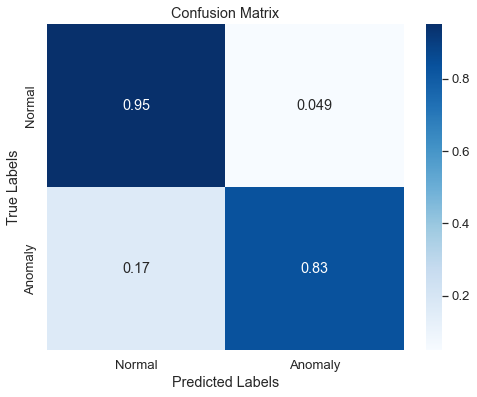

In [297]:
cm = confusion_matrix(y_train, anomaly_train,normalize='true')

# Define the class labels
class_labels = ['Normal', 'Anomaly']

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set the plot's labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [269]:
# sns.distplot(anomaly_score)

In [270]:
####

X_test_normalized = scaler.transform(X_test)
xtestpred = predict(model = trained_model,test_data = X_test_normalized)
xtestpred.shape


torch.Size([33244, 9])

In [273]:
anomaly_score_test = mse(xtestpred,X_test_normalized)

anomaly_test = anomaly_score_test>2*np.mean(anomaly_score)
anomaly_test = anomaly_test.astype(int)

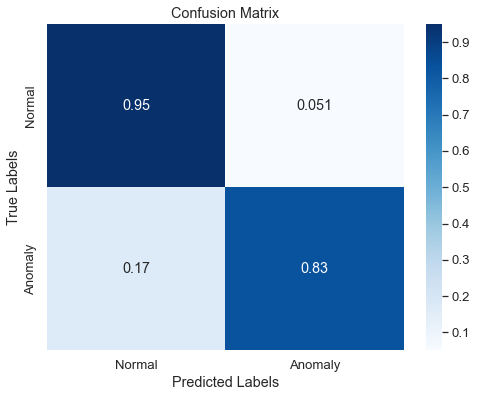

In [291]:
cm = confusion_matrix(y_test, anomaly_test,normalize='true')

# Define the class labels
class_labels = ['Normal', 'Anomaly']

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set the plot's labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()